# **Análisis de Sentimientos de Review de Películas**

Dataset: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis

Instalar Torch v2.3

In [ ]:
!pip install torch==2.3

Instalar torchtext v0.18

In [ ]:
!pip install torchtext

In [ ]:
################!pip uninstall -y torchtext

In [ ]:
########import torch
#########print(torch.__version__)

## **Librerías**

In [3]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


## **Carga del dataset**

In [9]:
data_df = pd.read_csv(r"/content/movie.csv")

In [10]:
data_df.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


## **Codificación de las etiquetas**

In [11]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [ ]:
data_df.dropna(inplace = True)
data_df.drop_duplicates(inplace = True)
data_df = data_df.drop(columns=data_df.columns[[0, 1]])
new_column_names = ['label', 'text']
data_df.columns = new_column_names
data_df = data_df.loc[data_df['label'] != 'Irrelevant'].copy()
data_df['label'] = label_encoder.fit_transform(data_df['label'])
print(len(data_df))

In [12]:
data_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## **Estadísticas de la variable Label**

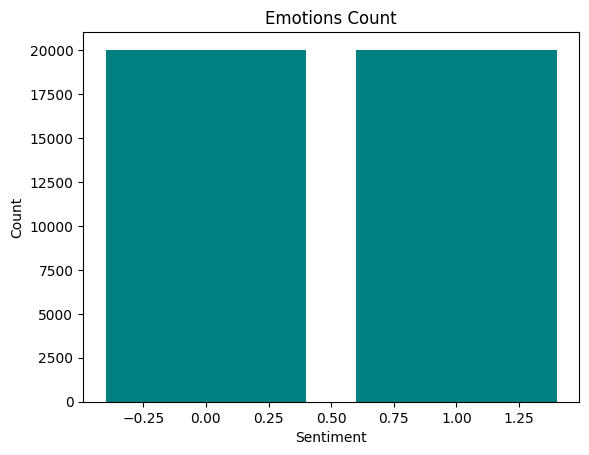

[20019, 19981]


In [13]:
emotions_count = data_df['label'].value_counts()
plt.bar(list(emotions_count.keys()), list(emotions_count), color='teal')
plt.xlabel("Sentiment",)
plt.ylabel('Count')
plt.title('Emotions Count')
plt.show()
print(list(emotions_count))

## **Stopwords**

In [14]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def clean_text(text, stem=True):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return text



tokenizer = get_tokenizer('basic_english')
train_data = data_df['text'].apply(clean_text).apply(tokenizer)
data_df['tokens'] = train_data
print(data_df['tokens'][:4])
print(data_df['label'][:4])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    [i, grew, up, b, watching, and, loving, the, t...
1    [when, i, put, this, movie, in, my, dvd, playe...
2    [why, do, people, who, do, not, know, what, a,...
3    [even, though, i, have, great, interest, in, b...
Name: tokens, dtype: object
0    0
1    0
2    0
3    0
Name: label, dtype: int64


## **División del set de entrenamiento y set de validación**

In [15]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_df, test_size=0.2, shuffle=True, random_state = 123)
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

label
0    16021
1    15979
Name: count, dtype: int64
label
1    4002
0    3998
Name: count, dtype: int64


## **Procesamiento del Dataset**

In [16]:
def build_vocab(texts):
        all_tokens = [token for text in texts for token in text]
        vocab = {token: idx for idx, token in enumerate(set(all_tokens))}
        vocab['<pad>'] = len(vocab)
        print(f"Vocabulary Length is: {len(vocab)}")
        return vocab, len(vocab)

vocab, VOCAB_SIZE = build_vocab(train_data)

Vocabulary Length is: 155308


In [17]:
BATCH_SIZE = 32
HIDDEN_DIM = 256
MAX_LEN = 50
EMBED_DIM = 128
pad_index = vocab["<pad>"]

In [18]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, max_len = MAX_LEN, pad_token = '<pad>'):
        self.texts = texts
        self.pad_token = pad_token
        self.max_length = max_len
        self.labels = labels
        self.vocab = vocab

    def text_to_tensor(self, text):
        text_indices = [self.vocab.get(token) for token in text]

        if len(text_indices) < self.max_length:
            text_indices = text_indices + [self.vocab[self.pad_token]] * (self.max_length - len(text_indices))
        else:
            text_indices = text_indices[:self.max_length]
        return torch.tensor(text_indices, dtype=torch.long)

    def label_to_tensor(self, label):
        return torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return self.text_to_tensor(text), self.label_to_tensor(label)

train_dataset = TextDataset(train_df['tokens'].tolist(), train_df['label'].tolist(), vocab = vocab)
test_dataset = TextDataset(test_df['tokens'].tolist(), test_df['label'].tolist(), vocab = vocab)

for text_tensor, label_tensor in test_dataset:
    print(f"text_tensor: {text_tensor}")
    print(f"label_tensor: {label_tensor}")
    tokenized_tensor = text_tensor
    break

text_tensor: tensor([  9828,  76466, 117427, 145105,  90299,  24467,  55327,   3913, 138926,
         31366, 117427, 112436,  72992,  66752,  71832,  31022,  94944, 110669,
         33766, 151780,  82569, 151164,  79474, 123627,   9828,  94776, 148728,
         54680,  66476,  71266,  84468,  41526, 123320, 143041,  40017, 111247,
         15449,  93508, 121984,  31366, 122065,  40017,  31366,  70476, 111247,
         60116,   2497, 145176,  66752,  29883])
label_tensor: 1


In [19]:
reverse_vocab = {v: k for k, v in vocab.items()}

# Function to convert tensor to sentence
def tensor_to_sentence(tensor):
    tokens = [reverse_vocab[idx.item()] for idx in tensor if idx.item() in reverse_vocab]
    return ' '.join(tokens)

print(tensor_to_sentence(tokenized_tensor))

this is the first must see film ive seen in the last year its wickedly funny incredibly original unbelievably great looking they went for this super cool widescreen technicolor look thats awesome to behold and it actually has depth in character and in what it says about society its really


In [20]:
device = ('cuda'
          if torch.cuda.is_available()
          else "mps"
          if torch.backends.mps.is_available()
          else "cpu"
          )


print(f"Using Device: {device}")

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

n = 0
for X, Y in test_dataloader:
    n+=1
    if n > 5:
        break
    else:
        print(f"Shape of X: {tensor_to_sentence(X[0])}")
        print(f"Shape of Y: {Y[0]}")

Using Device: cuda
Shape of X: this is the first must see film ive seen in the last year its wickedly funny incredibly original unbelievably great looking they went for this super cool widescreen technicolor look thats awesome to behold and it actually has depth in character and in what it says about society its really
Shape of Y: 1
Shape of X: i just wanted to inform anyone who may be interested that the the movie new jersey drive was my personal favorite off alltime i admire the work nick gomez and spike lee put into this masterpiece of a movie this movie made quite an impression on me because of its
Shape of Y: 1
Shape of X: i just saw this cartoon for the first time and recognized the caricatures of famous black entertainers cab calloway bessie smith not josephine baker or sophie tucker who was white thomas fats waller bill bojangles robinson stepin fetchit notwithstanding louis armstrong and the chorus girls are out of the famed
Shape of Y: 1
Shape of X: my friend bought the movie

## **Modelo GRU**

In [21]:
class GRUModel(nn.Module):
    def __init__(self):
            super().__init__()
            self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
            self.gru = nn.GRU(EMBED_DIM, HIDDEN_DIM, dropout=0.3, batch_first=True)
            self.fc = nn.Linear(HIDDEN_DIM, 3)
            self.dropout = nn.Dropout(0.3)
            self.sigmoid = nn.Sigmoid()
            self.no_layers = 1



    def forward(self, x, hidden):
            batch_size = x.size(0)
            embedded = self.embedding(x)
            output, hidden = self.gru(embedded)
            output = self.dropout(output[:, -1])
            output = self.fc(output)


            return output, hidden

    def init_hidden(self, batch_size):

        h0 = torch.zeros((self.no_layers,batch_size,HIDDEN_DIM)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,HIDDEN_DIM)).to(device)
        hidden = (h0,c0)
        return hidden

## **Modelo RNN**

In [22]:
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        self.rnn = nn.RNN(EMBED_DIM, HIDDEN_DIM, dropout=0.4, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM, 3)
        self.dropout = nn.Dropout(0.4)
        self.sigmoid = nn.Sigmoid()
        self.no_layers = 1

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = self.dropout(output[:, -1])
        output = self.fc(output)

        return output, hidden

    def init_hidden(self, batch_size):

        h0 = torch.zeros((self.no_layers,batch_size,HIDDEN_DIM)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,HIDDEN_DIM)).to(device)
        hidden = (h0,c0)
        return hidden

In [24]:
gru_model = GRUModel().to(device)
rnn_model = RNNModel().to(device)
print(gru_model)
print('---------------')
print(rnn_model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


GRUModel(
  (embedding): Embedding(155308, 128)
  (gru): GRU(128, 256, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)
---------------
RNNModel(
  (embedding): Embedding(155308, 128)
  (rnn): RNN(128, 256, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (sigmoid): Sigmoid()
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [25]:
for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    h = gru_model.init_hidden(BATCH_SIZE)
    h = tuple([each.data for each in h])
    pred, h = gru_model(X, h)
    print(f"Shape of X: {tensor_to_sentence(X[1])}")
    print(f"Shape of Y: {Y.shape}")
    print(f"pred shape: {pred.shape}")
    break

Shape of X: i remember watching this as a child in the uk mesmerized by the story and laurence oliviers narration we would talk about nothing else at school the next day i imagine the ratings for the first showing were huge this is quite simply the best most comprehensive documentary series despite
Shape of Y: torch.Size([32])
pred shape: torch.Size([32, 3])


In [26]:
loss_func_rnn = torch.nn.CrossEntropyLoss().to(device)
loss_func_gru = torch.nn.CrossEntropyLoss().to(device)
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=1e-3)
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

In [27]:
def get_accuracy(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label).item()

In [28]:
CLIP = 1

def train(dataloader, model, loss_fn, optimizer, train_losses):
    size = len(dataloader.dataset)
    model.train()
    h = model.init_hidden(BATCH_SIZE)
    loss_sum = 0
    accuracy = 0
    num_batches = len(dataloader)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        h = tuple([each.data for each in h])
        pred, h = model(x, h)
        loss = loss_fn(pred, y)
        loss_sum += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()
        optimizer.zero_grad()
        accuracy += get_accuracy(pred, y)
        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

    mean_loss = loss_sum / num_batches
    accuracy /= size
    train_losses.append(mean_loss)
    print(f"Training loss: {mean_loss:>7f}")
    print(f"Training accuracy: {(accuracy*100):>7f}")

In [29]:
def test(dataloader, model, loss_fn, test_losses):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    h = model.init_hidden(BATCH_SIZE)
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            h = tuple([each.data for each in h])
            pred, h = model(x, h)
            test_loss += loss_fn(pred, y).item()
            accuracy += get_accuracy(pred, y)
    test_loss /= num_batches
    accuracy /= size
    print("________")
    print(f"Test loss: {test_loss:>7f}")
    print(f"Test accuracy: {(accuracy*100):>0.1f}%")
    test_losses.append(test_loss)

## **Entrenamiento GRU**

In [30]:
train_losses = []
test_losses = []

for i in range(10):
    print(f'Epoch {i} -----------------------------------')
    train(train_dataloader, gru_model, loss_func_gru, optimizer_gru, train_losses)
    test(test_dataloader, gru_model, loss_func_gru, test_losses)

print('Finished Training')

Epoch 0 -----------------------------------
loss: 1.083286 [   32/32000]
loss: 0.612808 [ 6432/32000]
loss: 0.523646 [12832/32000]
loss: 0.580631 [19232/32000]
loss: 0.528033 [25632/32000]
Training loss: 0.592047
Training accuracy: 66.303125
________
Test loss: 0.486104
Test accuracy: 75.7%
Epoch 1 -----------------------------------
loss: 0.585186 [   32/32000]
loss: 0.450038 [ 6432/32000]
loss: 0.327967 [12832/32000]
loss: 0.336284 [19232/32000]
loss: 0.342756 [25632/32000]
Training loss: 0.407362
Training accuracy: 81.278125
________
Test loss: 0.463235
Test accuracy: 77.9%
Epoch 2 -----------------------------------
loss: 0.389647 [   32/32000]
loss: 0.289924 [ 6432/32000]
loss: 0.291034 [12832/32000]
loss: 0.194567 [19232/32000]
loss: 0.143257 [25632/32000]
Training loss: 0.280081
Training accuracy: 88.446875
________
Test loss: 0.544250
Test accuracy: 77.9%
Epoch 3 -----------------------------------
loss: 0.237078 [   32/32000]
loss: 0.154816 [ 6432/32000]
loss: 0.200215 [12832/

In [31]:
print(train_losses)

[0.5920469211935997, 0.40736223314702513, 0.28008144397847357, 0.1618224008944817, 0.07924414234585128, 0.043803908444184345, 0.027868620518405805, 0.02189128773806442, 0.01716906871840911, 0.014408707079607666]


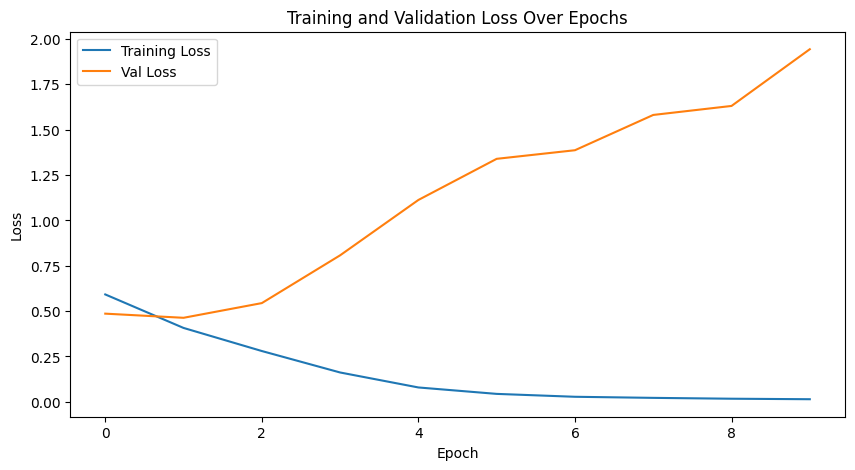

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [33]:
for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    h = gru_model.init_hidden(BATCH_SIZE)
    h = tuple([each.data for each in h])
    pred, h = gru_model(X, h)
    print(f"Shape of X: {tensor_to_sentence(X[10])}")
    print(f"Shape of Y: {Y[10]}")
    print(f"pred shape: {pred[10]}")
    x = X
    y = Y
    break

Shape of X: have to disagree with people saying that this is a lousy horror film with good acting and camerawork id say its an okay horror flick ruined by shockingly abysmal acting and poor camerawork watch juon the grudge instead of wasting your time with this garbage the principal idea behind the
Shape of Y: 0
pred shape: tensor([ 11.8716,  -9.8334, -10.6682], device='cuda:0',
       grad_fn=<SelectBackward0>)


tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')


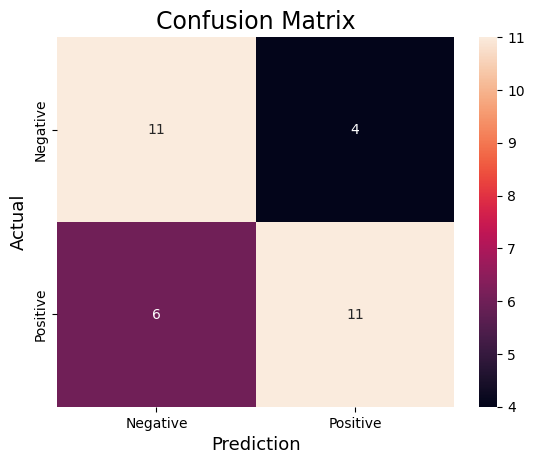

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix on 1 batch in the validation set

h = gru_model.init_hidden(BATCH_SIZE)
h = tuple([each.data for each in h])
predicted, h = gru_model(x, h)
print(y)
print(predicted.argmax(1))
y = y.cpu().detach().numpy()
cm = confusion_matrix(y, predicted.argmax(1).cpu().detach().numpy())
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

## **Entrenamiento RNN**

In [35]:
train_losses = []
test_losses = []

for i in range(10):
    print(f'Epoch {i} -----------------------------------')
    train(train_dataloader, rnn_model, loss_func_rnn, optimizer_rnn, train_losses)
    test(test_dataloader, rnn_model, loss_func_rnn, test_losses)

print('Finished Training')

Epoch 0 -----------------------------------
loss: 1.084594 [   32/32000]
loss: 0.734198 [ 6432/32000]
loss: 0.669566 [12832/32000]
loss: 0.706756 [19232/32000]
loss: 0.676565 [25632/32000]
Training loss: 0.714677
Training accuracy: 49.931250
________
Test loss: 0.693927
Test accuracy: 50.7%
Epoch 1 -----------------------------------
loss: 0.676482 [   32/32000]
loss: 0.711386 [ 6432/32000]
loss: 0.610289 [12832/32000]
loss: 0.624959 [19232/32000]
loss: 0.658621 [25632/32000]
Training loss: 0.705933
Training accuracy: 52.621875
________
Test loss: 0.693077
Test accuracy: 52.3%
Epoch 2 -----------------------------------
loss: 0.747492 [   32/32000]
loss: 0.671893 [ 6432/32000]
loss: 0.646436 [12832/32000]
loss: 0.585717 [19232/32000]
loss: 0.625150 [25632/32000]
Training loss: 0.686145
Training accuracy: 57.209375
________
Test loss: 0.692319
Test accuracy: 55.3%
Epoch 3 -----------------------------------
loss: 0.658614 [   32/32000]
loss: 0.598498 [ 6432/32000]
loss: 0.521144 [12832/

In [36]:
print(train_losses)

[0.7146774815320969, 0.7059326273798943, 0.6861445124745369, 0.6381235372722149, 0.5914003116190434, 0.5252011438012123, 0.4702337493300438, 0.412227903354913, 0.37038986942172053, 0.3532294149808586]


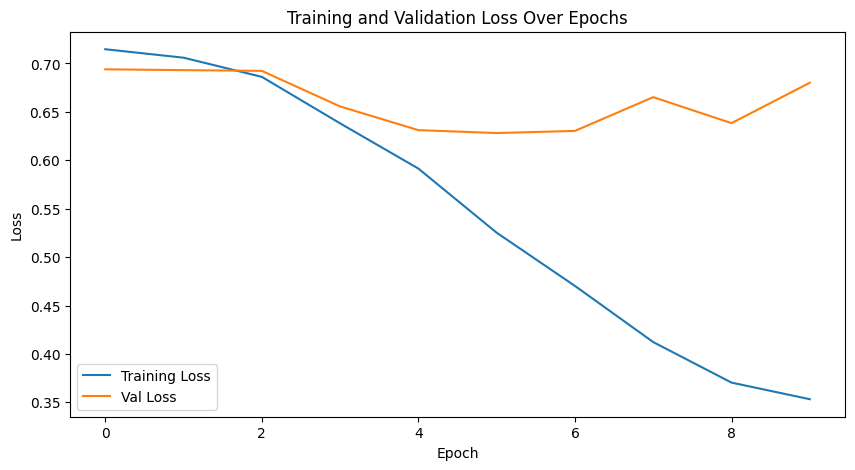

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [38]:
for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    h = rnn_model.init_hidden(BATCH_SIZE)
    h = tuple([each.data for each in h])
    pred, h = rnn_model(X, h)
    print(f"Shape of X: {tensor_to_sentence(X[10])}")
    print(f"Shape of Y: {Y[10]}")
    print(f"pred shape: {pred[10]}")
    x = X
    y = Y
    break

Shape of X: have to disagree with people saying that this is a lousy horror film with good acting and camerawork id say its an okay horror flick ruined by shockingly abysmal acting and poor camerawork watch juon the grudge instead of wasting your time with this garbage the principal idea behind the
Shape of Y: 0
pred shape: tensor([  2.3740,  -0.8590, -10.5686], device='cuda:0',
       grad_fn=<SelectBackward0>)


tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')


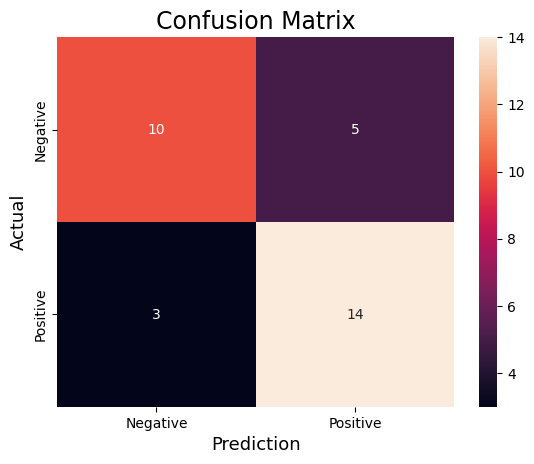

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix on 1 batch in the validation set

h = rnn_model.init_hidden(BATCH_SIZE)
h = tuple([each.data for each in h])
predicted, h = rnn_model(x, h)
print(y)
print(predicted.argmax(1))
y = y.cpu().detach().numpy()
cm = confusion_matrix(y, predicted.argmax(1).cpu().detach().numpy())
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()